Data : https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from keras import utils 
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,Input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model

In [2]:
train_dir = 'data/Training/'
test_dir = 'data/Testing/'

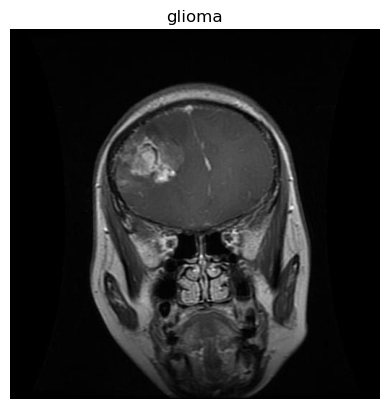

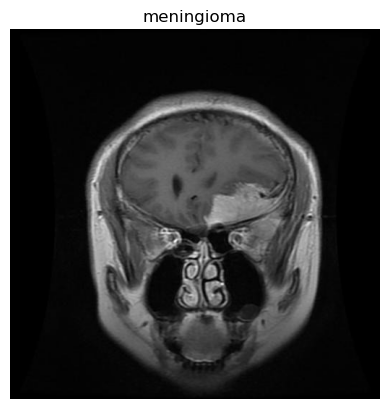

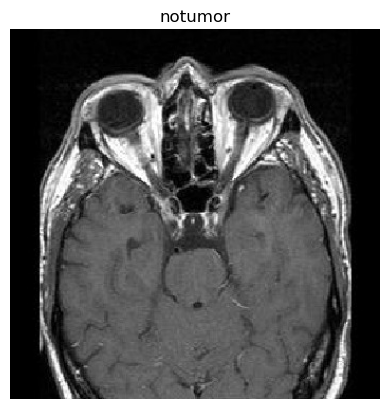

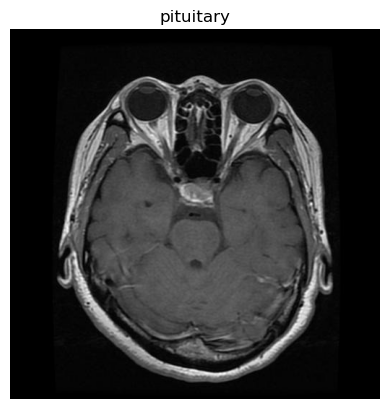

In [3]:
CATEGORIES = ["glioma","meningioma","notumor","pituitary"]
for category in CATEGORIES:
    path = os.path.join(train_dir,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
        plt.title(category)
        plt.axis("off")
        plt.show()
        break


(-0.5, 149.5, 149.5, -0.5)

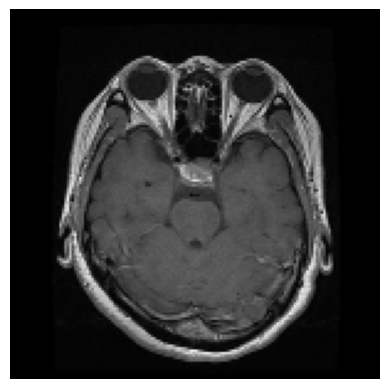

In [4]:
IMG_SIZE = 150
new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))    
plt.imshow(new_array)
plt.axis("off")

In [5]:
training_data = []

for category in CATEGORIES:
    path = os.path.join(train_dir,category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
        training_data.append([new_array,class_num])



In [6]:
len(training_data)

5712

In [7]:
X = []
y = []
for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE)
print(X.shape)
X = X/255.0  
X = X.reshape(-1,150,150,1)
print(X.shape)

(5712, 150, 150)
(5712, 150, 150, 1)


In [8]:
y = to_categorical(y, num_classes = 4)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_val.shape)

x_train shape (4569, 150, 150, 1)
x_test shape (1143, 150, 150, 1)
y_train shape (4569, 4)
y_test shape (1143, 4)


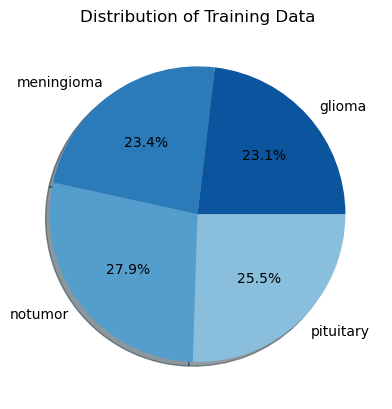

In [10]:
category_count = []
for category in CATEGORIES:
    path = os.path.join(train_dir,category)
    category_count.append(len(os.listdir(path)))

cmap = sns.color_palette("Blues")
plt.pie(category_count, labels=CATEGORIES, shadow=True, autopct='%1.1f%%', colors=cmap[::-1])
plt.title('Distribution of Training Data')
plt.show()

## Basic CNN model 

In [11]:
model = Sequential()

model.add(Conv2D(filters =64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (150,150,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))


model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=['accuracy', 
                                                               tf.keras.metrics.Precision(0.5),
                                                               tf.keras.metrics.Recall(0.5)])

In [12]:
epochs = 30  
batch_size = 32
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 128)       0

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

In [13]:
history = model.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                    epochs = epochs, 
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_data = (X_val,y_val),
                    validation_steps=len(X_val) // batch_size,
                    callbacks=callback) 


Epoch 1/30
142/142 [==============================] - 196s 1s/step - loss: 1.0885 - accuracy: 0.5045 - precision: 0.7549 - recall: 0.2790 - val_loss: 0.7657 - val_accuracy: 0.6728 - val_precision: 0.7651 - val_recall: 0.5416
Epoch 2/30
142/142 [==============================] - 189s 1s/step - loss: 0.7186 - accuracy: 0.7055 - precision: 0.7754 - recall: 0.6299 - val_loss: 0.5745 - val_accuracy: 0.7682 - val_precision: 0.8104 - val_recall: 0.7218
Epoch 3/30
142/142 [==============================] - 187s 1s/step - loss: 0.5903 - accuracy: 0.7728 - precision: 0.8097 - recall: 0.7229 - val_loss: 0.5908 - val_accuracy: 0.7542 - val_precision: 0.7786 - val_recall: 0.7262
Epoch 4/30
142/142 [==============================] - 189s 1s/step - loss: 0.5173 - accuracy: 0.7963 - precision: 0.8216 - recall: 0.7624 - val_loss: 0.4212 - val_accuracy: 0.8399 - val_precision: 0.8556 - val_recall: 0.8084
Epoch 5/30
142/142 [==============================] - 184s 1s/step - loss: 0.4692 - accuracy: 0.8177

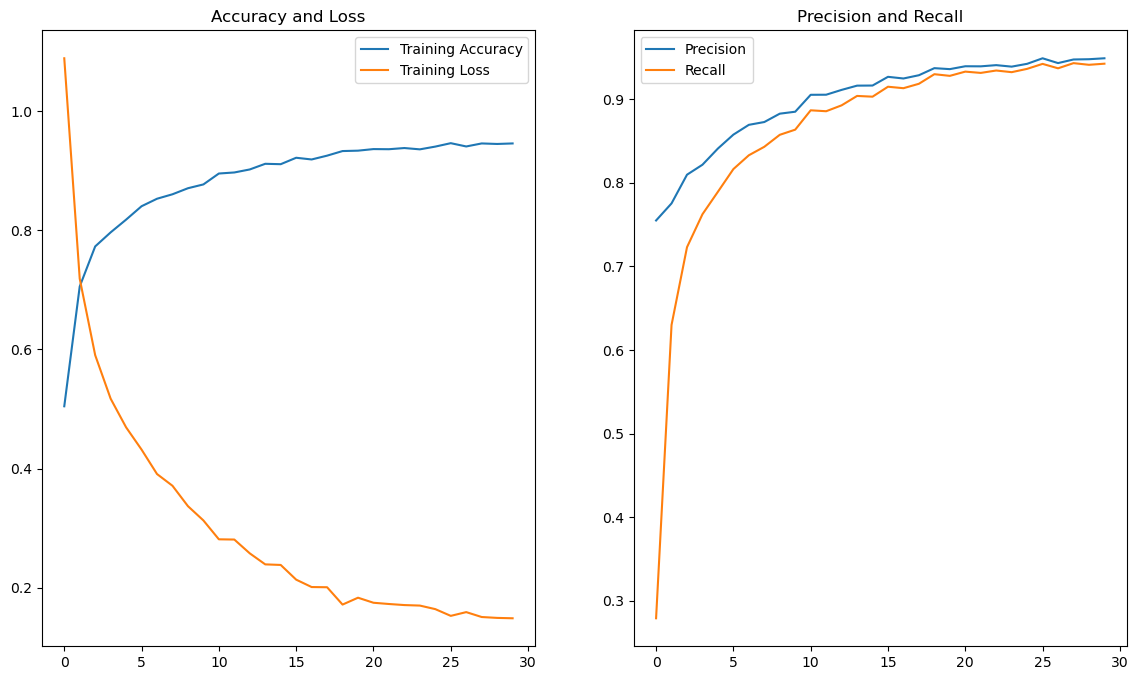

In [14]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

precision = history.history['precision']
recall =history.history['recall']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, train_loss, label='Training Loss')

plt.title('Accuracy and Loss')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(epochs_range, precision, label='Precision')
plt.plot(epochs_range, recall, label='Recall')

plt.title('Precision and Recall')
plt.legend()
plt.show()

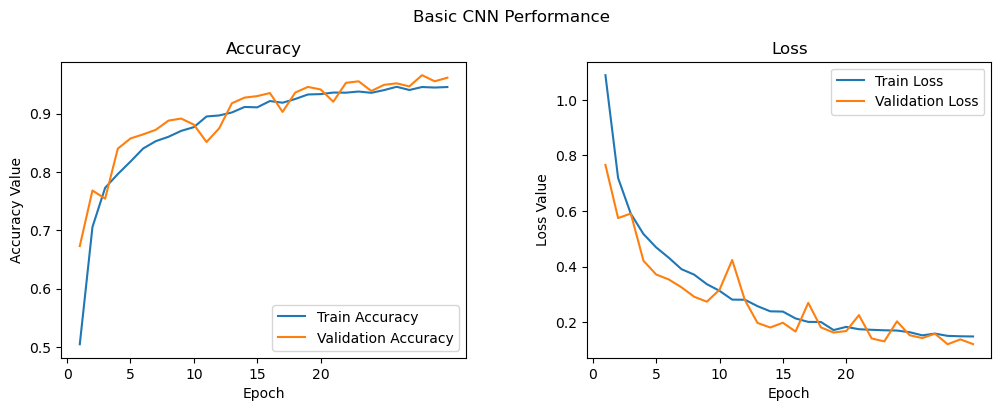

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


In [16]:
model.save('trained_model_1.h5')

In [15]:
model = load_model('trained_model_1.h5')

In [16]:
testing_data = []
for category in CATEGORIES:
    path = os.path.join(test_dir,category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
        testing_data.append([new_array,class_num])

X_test = []
y_test = []
for features,label in testing_data:
    X_test.append(features)
    y_test.append(label)
X_test = np.array(X_test).reshape(-1,IMG_SIZE,IMG_SIZE)
X_test = X_test/255.0  
X_test = X_test.reshape(-1,150,150,1)
y_test = to_categorical(y_test, num_classes = 4)

In [18]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

41/41 [==============================] - 12s 280ms/step


Testing Accuracy: 95.80%
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       300
           1       0.96      0.89      0.92       306
           2       0.95      1.00      0.97       405
           3       0.96      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



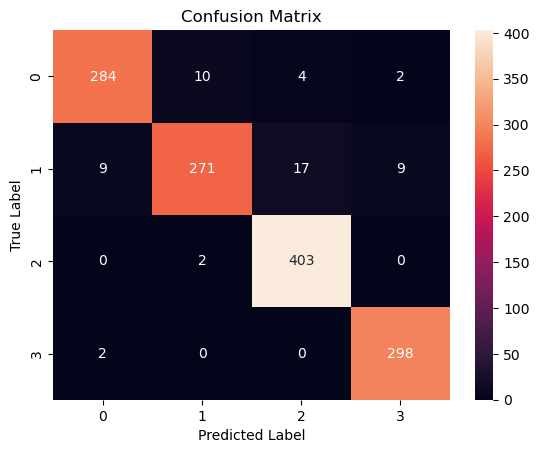

In [19]:
accuracy = accuracy_score(np.argmax(y_test,axis=1), y_pred)
print("Testing Accuracy: {:.2f}%".format(accuracy*100))

print(classification_report(np.argmax(y_test,axis=1), y_pred))

cm = confusion_matrix(np.argmax(y_test,axis=1), y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [20]:
loss, acc, prec, rec = model.evaluate(X_test,y_test)

41/41 [==============================] - 12s 280ms/step - loss: 0.1323 - accuracy: 0.9580 - precision: 0.9594 - recall: 0.9558


## Without Data Augmentation

In [42]:
history2 = model.fit(X_train,y_train, 
                    batch_size=batch_size,
                    epochs = epochs, 
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_data = (X_val,y_val),
                    validation_steps=len(X_val) // batch_size,
                    callbacks=callback) 

Epoch 1/30
142/142 [==============================] - 156s 1s/step - loss: 1.0323 - accuracy: 0.5445 - precision_1: 0.7525 - recall_1: 0.3358 - val_loss: 0.9245 - val_accuracy: 0.5813 - val_precision_1: 0.6786 - val_recall_1: 0.4902
Epoch 2/30
142/142 [==============================] - 150s 1s/step - loss: 0.6447 - accuracy: 0.7452 - precision_1: 0.7885 - recall_1: 0.6910 - val_loss: 0.6405 - val_accuracy: 0.7232 - val_precision_1: 0.7672 - val_recall_1: 0.6768
Epoch 3/30
142/142 [==============================] - 150s 1s/step - loss: 0.4802 - accuracy: 0.8195 - precision_1: 0.8402 - recall_1: 0.7902 - val_loss: 0.4098 - val_accuracy: 0.8402 - val_precision_1: 0.8643 - val_recall_1: 0.8188
Epoch 4/30
142/142 [==============================] - 154s 1s/step - loss: 0.4194 - accuracy: 0.8406 - precision_1: 0.8592 - recall_1: 0.8215 - val_loss: 0.3617 - val_accuracy: 0.8679 - val_precision_1: 0.8848 - val_recall_1: 0.8366
Epoch 5/30
142/142 [==============================] - 151s 1s/step -

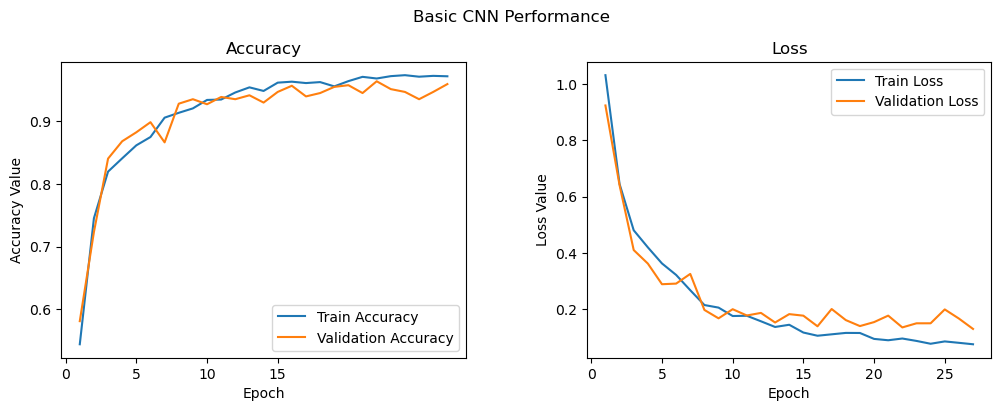

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,28))
ax1.plot(epoch_list, history2.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history2.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 18, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history2.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history2.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 28, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


In [45]:
model.save('trained_model_2.h5')

In [46]:
model = load_model('trained_model_2.h5')

In [47]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

41/41 [==============================] - 9s 208ms/step


Testing Accuracy: 96.03%
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       300
           1       0.93      0.91      0.92       306
           2       0.98      1.00      0.99       405
           3       0.98      0.99      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



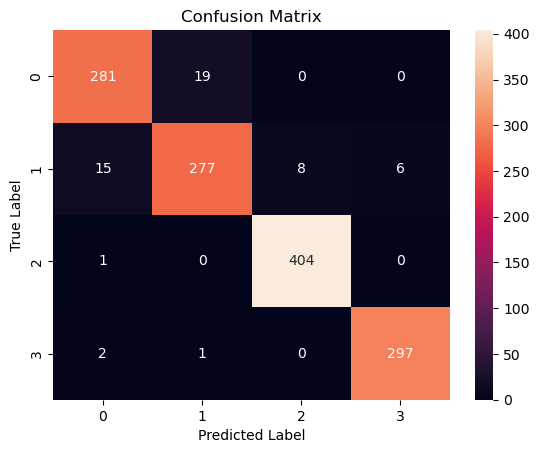

In [48]:
accuracy = accuracy_score(np.argmax(y_test,axis=1), y_pred)
print("Testing Accuracy: {:.2f}%".format(accuracy*100))

print(classification_report(np.argmax(y_test,axis=1), y_pred))

cm = confusion_matrix(np.argmax(y_test,axis=1), y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [49]:
loss, acc, prec, rec = model.evaluate(X_test,y_test)

41/41 [==============================] - 9s 205ms/step - loss: 0.1220 - accuracy: 0.9603 - precision_1: 0.9625 - recall_1: 0.9596


## ResNet50V2

In [17]:
from tensorflow.keras.applications import ResNet50V2

resnet_model = ResNet50V2(weights='imagenet', include_top=False)

for layer in resnet_model.layers:
    layer.trainable = False

In [18]:
input_layer = Input(shape=(None, None, 1), name='gray_input')
rgb_input = tf.keras.backend.repeat_elements(input_layer, rep=3, axis=3)
resized_input = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(rgb_input)

Since this model is trained on an RGB dataset, and our images are grayscale, we added a new input layer to the existing model that accepts grayscale images with a single channel. 

In [19]:
resnet_output = resnet_model(resized_input)

flatten_layer = Flatten()(resnet_output)
output_layer = Dense(units=4, activation='softmax')(flatten_layer)

model_resnet = Model(inputs=input_layer, outputs=output_layer)

model_resnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 
                                                               tf.keras.metrics.Precision(0.5),
                                                               tf.keras.metrics.Recall(0.5)])

In [20]:
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 gray_input (InputLayer)        [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 tf.split (TFOpLambda)          [(None, None, None,  0           ['gray_input[0][0]']             
                                 1)]                                                              
                                                                                                  
 tf.concat (TFOpLambda)         (None, None, None,   0           ['tf.split[0][0]',               
                                3)                                'tf.split[0][0]',           

In [26]:
history3 = model_resnet.fit(X_train,y_train, 
                    batch_size=batch_size,
                    epochs = epochs, 
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_data = (X_val,y_val),
                    validation_steps=len(X_val) // batch_size,
                    callbacks=callback) 


Epoch 1/30
142/142 [==============================] - 205s 1s/step - loss: 2.1047 - accuracy: 0.8534 - precision_3: 0.8539 - recall_3: 0.8530 - val_loss: 0.9526 - val_accuracy: 0.9045 - val_precision_3: 0.9045 - val_recall_3: 0.9045
Epoch 2/30
142/142 [==============================] - 205s 1s/step - loss: 0.5751 - accuracy: 0.9559 - precision_3: 0.9559 - recall_3: 0.9559 - val_loss: 1.1693 - val_accuracy: 0.9375 - val_precision_3: 0.9375 - val_recall_3: 0.9375
Epoch 3/30
142/142 [==============================] - 205s 1s/step - loss: 0.2309 - accuracy: 0.9771 - precision_3: 0.9771 - recall_3: 0.9771 - val_loss: 1.7438 - val_accuracy: 0.9250 - val_precision_3: 0.9250 - val_recall_3: 0.9250
Epoch 4/30
142/142 [==============================] - 199s 1s/step - loss: 0.2652 - accuracy: 0.9793 - precision_3: 0.9793 - recall_3: 0.9793 - val_loss: 0.9683 - val_accuracy: 0.9429 - val_precision_3: 0.9429 - val_recall_3: 0.9429
Epoch 5/30
142/142 [==============================] - 199s 1s/step -

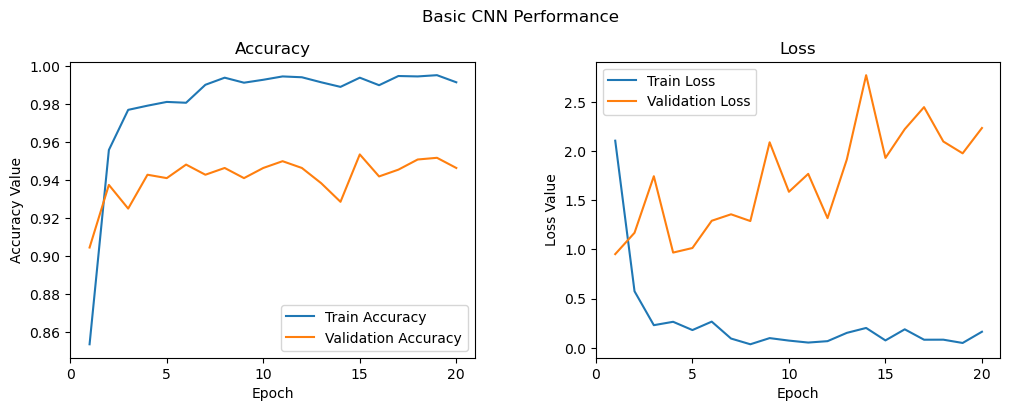

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, history3.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history3.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 21, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history3.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history3.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 21, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


In [39]:
model_resnet.save('trained_model_3.h5')

In [40]:
model = load_model('trained_model_3.h5')

In [41]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

41/41 [==============================] - 47s 1s/step


Testing Accuracy: 94.36%
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       300
           1       0.83      0.95      0.89       306
           2       0.98      1.00      0.99       405
           3       1.00      0.95      0.97       300

    accuracy                           0.94      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.95      0.94      0.94      1311



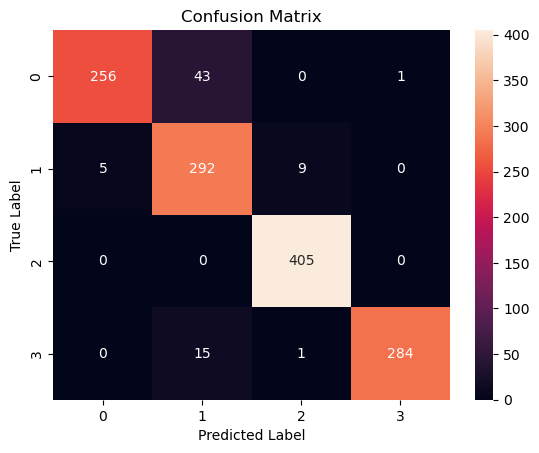

In [42]:
accuracy = accuracy_score(np.argmax(y_test,axis=1), y_pred)
print("Testing Accuracy: {:.2f}%".format(accuracy*100))

print(classification_report(np.argmax(y_test,axis=1), y_pred))

cm = confusion_matrix(np.argmax(y_test,axis=1), y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [43]:
loss, acc, prec, rec = model.evaluate(X_test,y_test)

41/41 [==============================] - 48s 1s/step - loss: 2.5036 - accuracy: 0.9436 - precision_3: 0.9436 - recall_3: 0.9436


## VGG16

In [21]:
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False)

for layer in vgg_model.layers:
    layer.trainable = False

vgg_output = vgg_model(resized_input)

flatten_layer = Flatten()(vgg_output)
dropout_layer=Dropout(0.5)(flatten_layer)
output_layer = Dense(units=4, activation='softmax')(dropout_layer)

model_vgg = Model(inputs=input_layer, outputs=output_layer)

model_vgg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 
                                                               tf.keras.metrics.Precision(0.5),
                                                               tf.keras.metrics.Recall(0.5)])



In [22]:
model_vgg.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 gray_input (InputLayer)        [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 tf.split (TFOpLambda)          [(None, None, None,  0           ['gray_input[0][0]']             
                                 1)]                                                              
                                                                                                  
 tf.concat (TFOpLambda)         (None, None, None,   0           ['tf.split[0][0]',               
                                3)                                'tf.split[0][0]',         

In [15]:
history4 = model_vgg.fit(X_train,y_train, 
                    batch_size=batch_size,
                    epochs = epochs, 
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_data = (X_val,y_val),
                    validation_steps=len(X_val) // batch_size,
                    callbacks=callback) 


Epoch 1/30
142/142 [==============================] - 398s 3s/step - loss: 0.5202 - accuracy: 0.8079 - precision_1: 0.8286 - recall_1: 0.7883 - val_loss: 0.2819 - val_accuracy: 0.8955 - val_precision_1: 0.9163 - val_recall_1: 0.8893
Epoch 2/30
142/142 [==============================] - 399s 3s/step - loss: 0.2550 - accuracy: 0.9057 - precision_1: 0.9126 - recall_1: 0.9002 - val_loss: 0.2015 - val_accuracy: 0.9232 - val_precision_1: 0.9277 - val_recall_1: 0.9170
Epoch 3/30
142/142 [==============================] - 398s 3s/step - loss: 0.2091 - accuracy: 0.9224 - precision_1: 0.9268 - recall_1: 0.9187 - val_loss: 0.2338 - val_accuracy: 0.9196 - val_precision_1: 0.9259 - val_recall_1: 0.9143
Epoch 4/30
142/142 [==============================] - 399s 3s/step - loss: 0.1593 - accuracy: 0.9392 - precision_1: 0.9438 - recall_1: 0.9361 - val_loss: 0.2582 - val_accuracy: 0.9045 - val_precision_1: 0.9082 - val_recall_1: 0.9009
Epoch 5/30
142/142 [==============================] - 402s 3s/step -

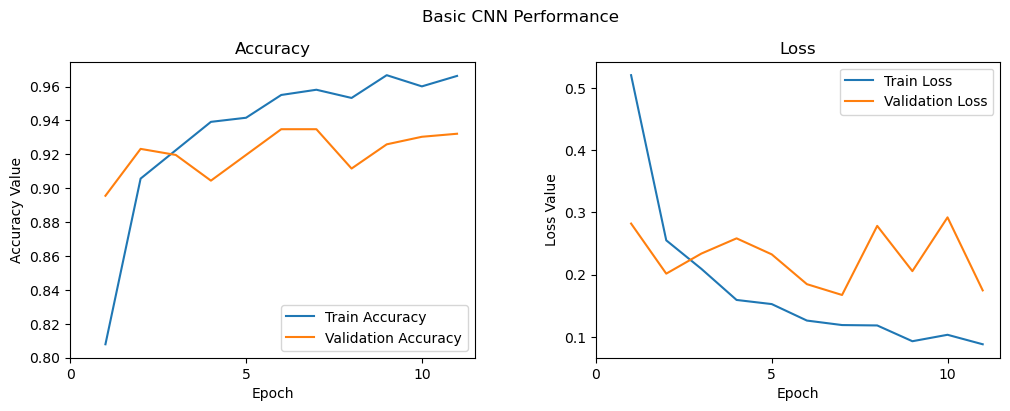

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,12))
ax1.plot(epoch_list, history4.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history4.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 12, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history4.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history4.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 12, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


In [19]:
model_vgg.save('trained_model_4.h5')

In [50]:
model = load_model('trained_model_4.h5')

In [51]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

41/41 [==============================] - 98s 2s/step


Testing Accuracy: 93.06%
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       300
           1       0.93      0.76      0.84       306
           2       0.97      1.00      0.99       405
           3       0.96      0.98      0.97       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.92      1311
weighted avg       0.93      0.93      0.93      1311



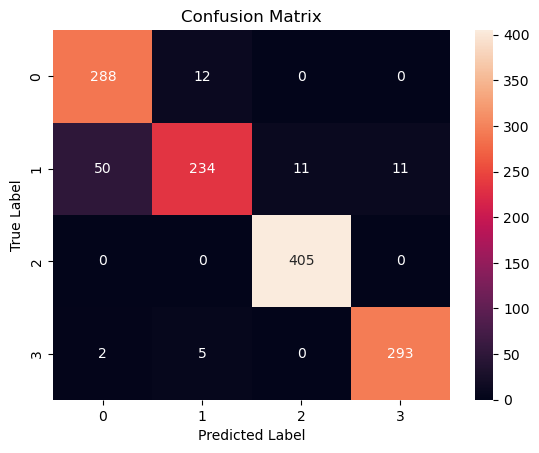

In [52]:
accuracy = accuracy_score(np.argmax(y_test,axis=1), y_pred)
print("Testing Accuracy: {:.2f}%".format(accuracy*100))

print(classification_report(np.argmax(y_test,axis=1), y_pred))

cm = confusion_matrix(np.argmax(y_test,axis=1), y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [53]:
loss, acc, prec, rec = model.evaluate(X_test,y_test)

41/41 [==============================] - 105s 3s/step - loss: 0.1702 - accuracy: 0.9306 - precision_1: 0.9318 - recall_1: 0.9275
